<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/ClassificationWithPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook does PCA on MNIST**




In [2]:
from google.colab import drive

ROOT = "/content/gdrive"

drive.mount(ROOT, force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
%pylab inline
import pickle
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [3]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test
  
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [0]:
pca_path = './gdrive/My Drive/PCA/mnist/'

In [63]:
from sklearn.decomposition import PCA




for ii in range(10):
  indices = np.where(targets_train==ii)
  x_train_class = x_train[indices]
  mask_0 = np.asarray(np.where(np.var(x_train_class, axis=0)==0.)[0])
  mask_1 = np.asarray(np.where(np.var(x_train_class, axis=0)>0.)[0])

  cut_train = x_train_class[:,mask_1]
  mean      = np.mean(cut_train, axis=0)
  num       = cut_train.shape[1]
  print(num)
  pca = PCA(svd_solver='full',n_components=num)
  pca.fit(cut_train)  

  pickle.dump([pca,mask_0, mask_1,mean], open(pca_path+'pca_on_%d_num_comp_full_inpainted.pkl'%ii,'wb'))



563
577
607
581
584
578
558
577
553
545


In [66]:
print(mask_1)

[ 39  40  41  43  44  45  59  60  62  63  64  67  68  69  70  71  72  73
  74  75  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249
 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271
 272 273 274 275 276 277 282 283 284 285 286 287 288 289 290 291 292 293
 294 295 296 297 298 299 300 301 302 303 304 305 311 312 313 314 315 316
 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334
 337 338 339 340 341 342 343 344 345 346 347 348 34

In [0]:
import numpy.linalg as lg
def get_probability_of_data(logdet,Cinv,data, mean):
  d    = len(data)
  data = data-mean
  Cinv_d = np.einsum('jk,...k->...j',Cinv,data)
#   plt.figure()
#   plt.imshow(Cinv_d[2].reshape(28,28))
#   plt.colorbar()
#   plt.show()
  
  logprob = -0.5*logdet-0.5*d*np.log((2*np.pi))-0.5*np.einsum('ij,ij->i',data, Cinv_d)
  return logprob

In [175]:
# do classification
nums = [500]
acc = np.zeros((len(nums),10))


for ll in range(len(nums)):
  num = nums[ll] 
  print(num, ll)
  for ii in range(10):
    print(ii)
    indices = np.where(targets_test==ii)
    x_test_class =x_test[indices]
    logprob=[]
    for jj in range(10):
      pca, mask_0, mask_1, mean = pickle.load(open(pca_path+'pca_on_%d_num_comp_full_inpainted.pkl'%(jj),'rb')) 
      
      inpaint   = np.random.randn(len(mask_0)*len(x_test_class))*0.01
      cut_test  = x_test_class
      cut_test[:,mask_0] = inpaint.reshape((len(x_test_class),len(mask_0)))
      
      sing     = pca.singular_values_[0:num]
      R        = pca.components_[0:num]

      sigma2   = np.mean(pca.explained_variance_[num::])
      
      C_       = np.zeros((28*28,28*28))
      mean_d   = np.zeros((28*28))
      
      C_pca    = np.dot(R.T,np.dot(np.diag(sing), R))
      
      kk = 0
      for nn in range(28*28):
        if nn in mask_1:
          C_[nn,mask_1] = C_pca[kk]
          C_[nn,nn]+=sigma2
          mean_d[nn] = mean[kk]
          kk+=1
        if nn in mask_0:
          C_[nn,nn] = 0.1
      
          
#       #C_ = C_+np.eye(len(C_))*
      
      
#       plt.figure()
#       plt.imshow(np.diag(C_).reshape((28,28)))
#       plt.colorbar()
#       plt.show()
      
#       plt.figure()
#       plt.imshow(mean_d.reshape((28,28)))
#       plt.colorbar()
#       plt.show()
      sign ,logdetC = lg.slogdet(C_)
      if ii==0:
        print(logdetC)
        ones = np.diag(np.dot(lg.inv(C_),C_))
        eigs = (np.linalg.eigvalsh(C_))
        print(min(ones),max(ones), max(ones-np.diag(np.diag(ones))))
        print('cond 1e6', max(eigs)/min(eigs)/1e6)
        
      logprob+=[get_probability_of_data(logdetC,lg.inv(C_),cut_test,mean_d)]
      

    correct = len(np.where(np.argsort(logprob, axis=0)[-1]==ii)[0])
    acc_ = np.float(correct)/np.float(len(x_test_class))
    print('acc:', acc_)
    acc[ll,ii]=acc_
    
#pickle.dump(acc, open(pca_path+'accuracies_addedvariance_testset.pkl','wb'))

500 0
0
-422.63678386348556
0.999999921778965 1.000000098634235 0.0
cond 1e6 51.44892000328845
-1328.077714008681
0.999046275316374 1.0008328882795468 0.0
cond 1e6 -966.8384496323786
-424.87995433665793
0.9999999976128642 1.000000002350535 0.0
cond 1e6 2.304094522956379
-401.0727823931528
0.99999996843529 1.0000000385909047 0.0
cond 1e6 8.379243014797597
-403.4663434830914
0.9999999974652027 1.0000000026778189 0.0
cond 1e6 3.6774075922436538
-365.717601391945
0.9999999977976586 1.000000002316483 0.0
cond 1e6 5.306781615942511
-404.6672866263781
0.9999999915687621 1.0000000083694196 0.0
cond 1e6 40.33662958088355
-479.3559799246268
0.9999999955233534 1.0000000097293835 0.0
cond 1e6 10.31035949931902
-268.9077606996664
0.9999999992027728 1.000000000914639 0.0
cond 1e6 25.88856164793225
-392.10909721092884
0.9999998283163167 1.0000001650691956 0.0
cond 1e6 115.66486743480694
acc: 0.9489795918367347
1


KeyboardInterrupt: ignored

In [0]:
acctest = pickle.load(open(pca_path+'accuracies_addedvariance_testset.pkl','rb'))
acc2test = pickle.load(open(pca_path+'accuracies_addedvariance_testset.pkl','rb'))

In [0]:
# nums = [10,20,30,40,50,60,70,80,90,100,200,300,400,500]
# for ii in range(10):
#   plt.semilogx(nums, acc1test[:,ii], marker='o',label='class %d'%ii)

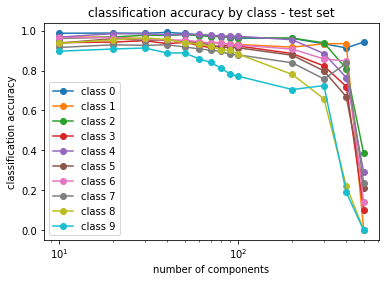

In [98]:
nums =  [10,20,30,40,50,60,70,80,90,100,200,300,400,500]
plt.title('classification accuracy by class - test set')
for ii in range(10):
  plt.semilogx(nums, acctest[:,ii], marker='o',label='class %d'%ii)
  plt.xlabel('number of components')
  plt.ylabel('classification accuracy')
  plt.legend()

No handles with labels found to put in legend.


0.9567052133091781


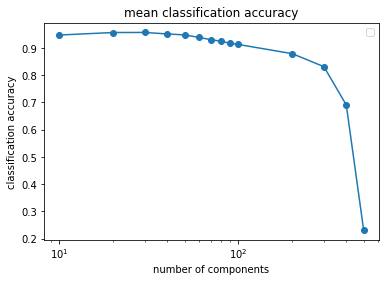

In [100]:
nums = [10,20,30,40,50,60,70,80,90,100,200,300,400,500]
plt.figure()
plt.title('mean classification accuracy')
plt.semilogx(nums, np.mean(acctest,axis=1), marker='o')
print(max(np.mean(acctest,axis=1)))
plt.xlabel('number of components')
plt.ylabel('classification accuracy')
plt.legend()
plt.show()

In [101]:
for jj in range(10):
      pca, _, _, _= pickle.load(open(pca_path+'pca_on_%d_num_comp_full_inpainted.pkl'%(jj),'rb')) 
      print(min(pca.singular_values_))

4.383058e-06
1.0252844e-05
1.5102141e-06
2.9009868e-06
3.4189654e-06
7.4171808e-06
1.3611575e-06
2.5060256e-06
9.851534e-07
1.690221e-06


In [86]:
# do classification
nums = [10,30,60,100,300,500]
# do classification
acc = np.zeros((len(nums),10))


for ll in range(len(nums)):
  num = nums[ll] 
  print(num, ll)
  for ii in range(10):
    print(ii)
    indices = np.where(targets_train==ii)
    x_test_class =x_train[indices]
    logprob=[]
    for jj in range(10):
      pca, mask_0, mask_1, mean = pickle.load(open(pca_path+'pca_on_%d_num_comp_full_inpainted.pkl'%(jj),'rb')) 
      
      inpaint   = np.random.randn(len(mask_0)*len(x_test_class))*0.01
      cut_test  = x_test_class
      cut_test[:,mask_0] = inpaint.reshape((len(x_test_class),len(mask_0)))
      
      sing     = pca.singular_values_[0:num]
      R        = pca.components_[0:num]

      sigma2   = np.mean(pca.explained_variance_[num::])
      
      C_       = np.zeros((28*28,28*28))
      mean_d   = np.zeros((28*28))
      
      C_pca    = np.dot(R.T,np.dot(np.diag(sing), R))
      
      kk = 0
      for nn in range(28*28):
        if nn in mask_1:
          C_[nn,mask_1] = C_pca[kk]
          mean_d[nn] = mean[kk]
          kk+=1
        if nn in mask_0:
          C_[nn:nn] = 0.1
          
      C_ = C_+np.eye(len(C_))*sigma2
      
#       plt.figure()
#       plt.imshow(np.diag(C_).reshape((28,28)))
#       plt.colorbar()
#       plt.show()
      
#       plt.figure()
#       plt.imshow(mean_d.reshape((28,28)))
#       plt.colorbar()
#       plt.show()
      
      #print(min(np.diag(C_)))
      sign ,logdetC = lg.slogdet(C_)
      logprob+=[get_probability_of_data(logdetC,lg.inv(C_),cut_test,mean_d)]
      

    correct = len(np.where(np.argsort(logprob, axis=0)[-1]==ii)[0])
    acc_ = np.float(correct)/np.float(len(x_test_class))
    print('acc:', acc_)
    acc[ll,ii]=acc_
    
pickle.dump(acc, open(pca_path+'accuracies_addedvariance_trainset.pkl','wb'))

10 0
0
acc: 0.981346309813463
1
acc: 0.9695315251849242
2
acc: 0.9446457326892109
3
acc: 0.9206038031758479
4
acc: 0.960279892982095
5
acc: 0.9349755881047492
6
acc: 0.9701070490809938
7
acc: 0.9352657004830918
8
acc: 0.9196612969847171
9
acc: 0.921411387329591
30 1
0
acc: 0.9894566098945661
1
acc: 0.9672419866150053
2
acc: 0.961755233494364
3
acc: 0.9378553224857871
4
acc: 0.9643959662481992
5
acc: 0.9462938304482912
6
acc: 0.9707129872752979
7
acc: 0.9466666666666667
8
acc: 0.9568360181743082
9
acc: 0.9504811547714515
60 2
0
acc: 0.9860097323600974
1
acc: 0.9584360690383938
2
acc: 0.9557165861513688
3
acc: 0.9335424426583023
4
acc: 0.9573986416958222
5
acc: 0.9380825565912118
6
acc: 0.9686931932942839
7
acc: 0.9321739130434783
8
acc: 0.9454770755885997
9
acc: 0.9434643143544507
100 3
0
acc: 0.9835766423357665
1
acc: 0.9566748855230714
2
acc: 0.9430354267310789
3
acc: 0.9125661634973534
4
acc: 0.9471084585305618
5
acc: 0.9207723035952063
6
acc: 0.9656635023227631
7
acc: 0.907439613526

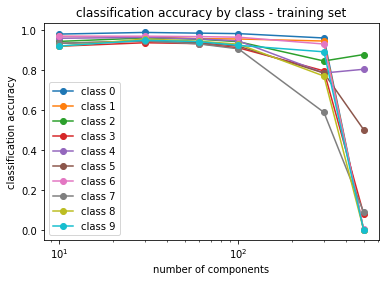

In [88]:
acctrain=pickle.load(open(pca_path+'accuracies_addedvariance_trainset.pkl','rb'))

nums = np.asarray([10,30,60,100,300,500])

plt.figure()
plt.title('classification accuracy by class - training set')
for ii in range(10):
  plt.semilogx(nums, acctrain[:,ii], marker='o',label='class %d'%ii)
  plt.xlabel('number of components')
  plt.ylabel('classification accuracy')
  plt.legend()
plt.show()

# plt.figure()
# plt.title('classification accuracy by class')
# for ii in range(10):
#   plt.semilogx(nums, acc1train[:,ii], marker='o',label='class %d'%ii)
#   plt.xlabel('number of components')
#   plt.ylabel('classification accuracy')
#   plt.legend()
# plt.show()

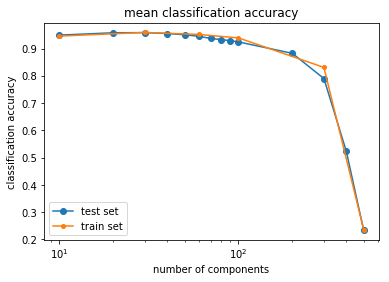

In [89]:

plt.figure()
plt.title('mean classification accuracy')
nums = [10,20,30,40,50,60,70,80,90,100,200,300,400,500]
plt.semilogx(nums, np.mean(acctest,axis=1), marker='o', label='test set')
nums = np.asarray([10,30,60,100,300,500])
plt.semilogx(nums, np.mean(acctrain,axis=1), marker='o',markersize=4,label='train set')
plt.xlabel('number of components')
plt.ylabel('classification accuracy')
plt.legend()
plt.show()

0
1


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


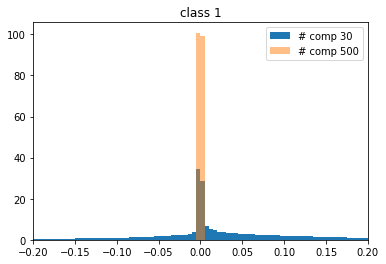

0
1


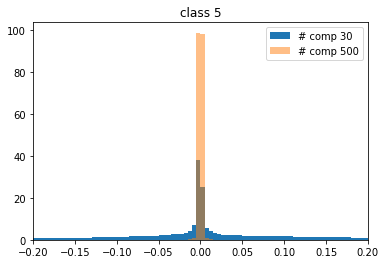

In [31]:
# do classification
nums = [30,500]

hists= np.zeros((len(nums),10,2,80))

for ii in [1,5]:
  plt.figure()
  plt.title('class %d'%ii)
  for ll in range(len(nums)):
    print(ll)
    num = nums[ll] 
    indices = np.where(targets_test==ii)
    x_test_class =x_test[indices]
    pca, mask, mean= pickle.load(open(pca_path+'pca_on_%d_num_comp_full.pkl'%(jj),'rb')) 
    cut_test = x_test_class[:,mask[0]]
    R        = pca.components_[0:num]
    Rd = np.einsum('ij,...j->...i', R,cut_test)
    RRd= np.einsum('ij,...j->...i', R.T, Rd)
    _ = plt.hist(((RRd - cut_test)).flatten(), range=(-0.2,0.2),bins=80, normed=True, alpha=(len(nums)-ll)/len(nums),label='# comp %d'%num)
  plt.xlim(-0.2,0.2)
  plt.legend()
  #plt.yscale('log')
  plt.show()


0


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


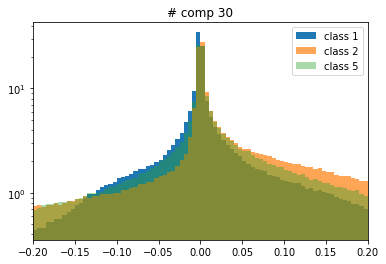

1


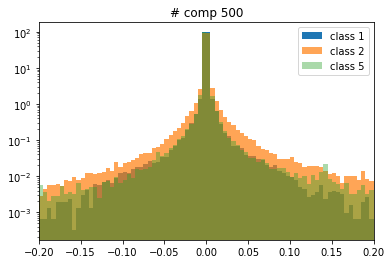

In [23]:
# do classification
nums = [30,500]

hists= np.zeros((len(nums),10,2,80))
for ll in range(len(nums)):
  print(ll)
  num = nums[ll] 
  plt.figure()
  plt.title('# comp %d'%num)
  alpha=1.
  for ii in [1,2,5]:
    indices = np.where(targets_test==ii)
    x_test_class =x_test[indices]
    pca, mask, mean = pickle.load(open(pca_path+'pca_on_%d_num_comp_full.pkl'%(jj),'rb')) 
    cut_test = x_test_class[:,mask[0]]
    R        = pca.components_[0:num]
    Rd = np.einsum('ij,...j->...i', R,cut_test)
    RRd= np.einsum('ij,...j->...i', R.T, Rd)
    _ = plt.hist(((RRd - cut_test)).flatten(), range=(-0.2,0.2),bins=80, normed=True,alpha=alpha, label='class %d'%ii)
    alpha-=0.3
  plt.yscale('log')
  plt.xlim(-0.2,0.2)
  plt.legend()
  plt.show()
